In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall #NAS

In [ ]:
DIR_MAIN = '/content/drive/MyDrive/CCPS-F2/CCPS/DataSetSplit/SplitDataset'
TEST_DIR = DIR_MAIN + '/test'

In [ ]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

In [ ]:
image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=TEST_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

Found 385 images belonging to 4 classes.


In [ ]:
dataset_labels = sorted(test_data_gen.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Benign' 'Early' 'Pre' 'Pro']


In [ ]:
import pandas as pd

In [ ]:
test_image_batch, test_label_batch = next(iter(test_data_gen))
true_label_ids = np.argmax(test_label_batch, axis=-1)
print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

# MOBILENET

In [ ]:
MobileNet_PATH = '/content/drive/MyDrive/CCPS-F2/CCPS/NewModels/MobileNet.h5'

In [ ]:
MobileNet = tf.keras.models.load_model(MobileNet_PATH,custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
tf_model_predictions_MobileNet = MobileNet.predict(test_image_batch)
tf_pred_dataframe_MobileNet = pd.DataFrame(tf_model_predictions_MobileNet)
tf_pred_dataframe_MobileNet.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe_MobileNet.head()

1/1 [==============================] - 8s 8s/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,0.000772,0.000425,0.000144,0.998659
1,0.036329,0.008917,0.953068,0.001686
2,0.000479,0.000568,0.998932,0.000021
3,0.000714,0.000013,0.999269,0.000004
4,0.987805,0.001738,0.000059,0.010399


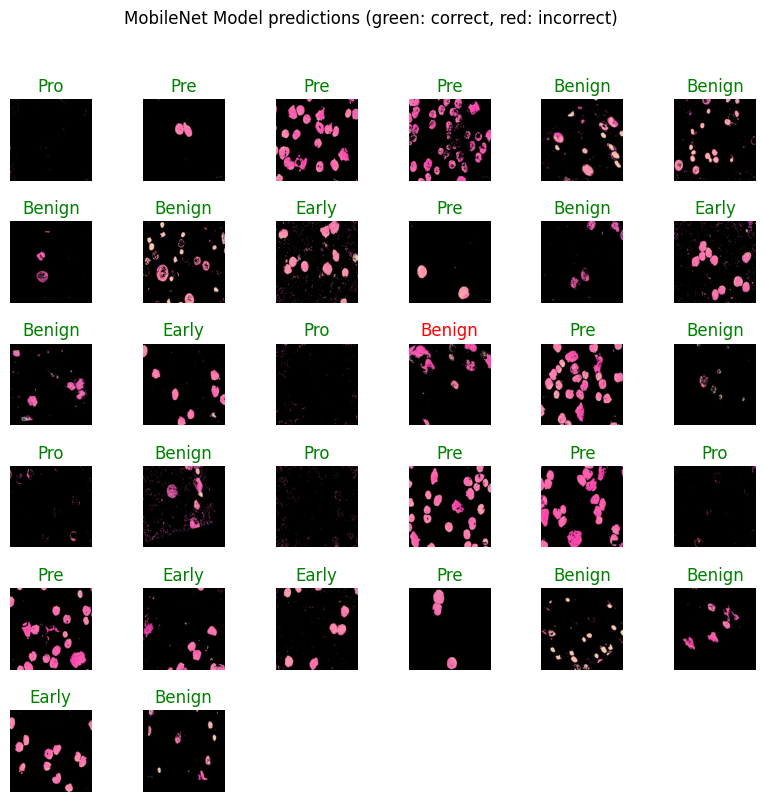

In [ ]:
predicted_ids_MobileNet = np.argmax(tf_model_predictions_MobileNet, axis=-1)
predicted_labels_MobileNet = dataset_labels[predicted_ids_MobileNet]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_MobileNet[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_MobileNet[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("MobileNet Model predictions (green: correct, red: incorrect)")

In [ ]:
results = MobileNet.evaluate(test_image_batch, test_label_batch)

1/1 [==============================] - 1s 641ms/step - loss: 0.1539 - acc: 0.9688


In [ ]:
results

[0.15386997163295746, 0.96875]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_MobileNet)
claRep

'              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96        11\n           1       1.00      1.00      1.00         6\n           2       1.00      1.00      1.00         9\n           3       1.00      0.83      0.91         6\n\n    accuracy                           0.97        32\n   macro avg       0.98      0.96      0.97        32\nweighted avg       0.97      0.97      0.97        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_MobileNet)
accuracy = accuracy_score(true_label_ids, predicted_ids_MobileNet)
precision = precision_score(true_label_ids, predicted_ids_MobileNet, average='macro')
recall = recall_score(true_label_ids, predicted_ids_MobileNet, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_MobileNet, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[11  0  0  0]
 [ 0  6  0  0]
 [ 0  0  9  0]
 [ 1  0  0  5]]
Accuracy: 0.96875
Precision: 0.9791666666666666
Recall: 0.9583333333333334
F1 Score: 0.9664031620553359


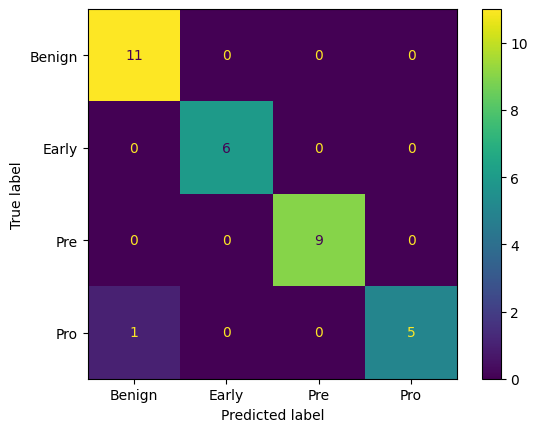

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Benign', 'Early', 'Pre', 'Pro'])
cm_display.plot()
plt.show()

Text(0, 0.5, 'TPR')

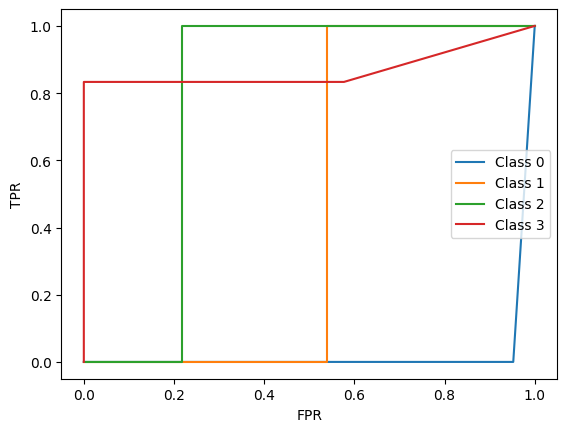

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

N_classes = 4
tpr,fpr,roc_auc = ([[]]*N_classes for _ in range(3))
f,ax = plt.subplots()
for i in range(N_classes):
    # fpr[i], tpr[i], _ = roc_curve(true_label_ids==i, predicted_ids_MobileNet)
    fpr[i], tpr[i], _ = roc_curve(true_label_ids.ravel()==i, predicted_ids_MobileNet.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax.plot(fpr[i],tpr[i])
plt.legend(['Class {:d}'.format(d) for d in range(N_classes)])
plt.xlabel('FPR')
plt.ylabel('TPR')

# 2. ResNet

In [ ]:
ResNet_PATH = '/content/drive/MyDrive/CCPS-F2/CCPS/NewModels/ResNet50_224.h5'

In [ ]:
ResNet = tf.keras.models.load_model(ResNet_PATH)

In [ ]:
tf_model_predictions_ResNet = ResNet.predict(test_image_batch)
tf_pred_dataframe_ResNet = pd.DataFrame(tf_model_predictions_ResNet)
tf_pred_dataframe_ResNet.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe_ResNet.head()

1/1 [==============================] - 3s 3s/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,0.059979,0.000554,0.055641,8.838260e-01
1,0.186479,0.515648,0.243182,5.469131e-02
2,0.000080,0.001383,0.998537,1.150033e-07
3,0.005071,0.010535,0.984388,6.001275e-06
4,0.960278,0.029951,0.002371,7.399968e-03


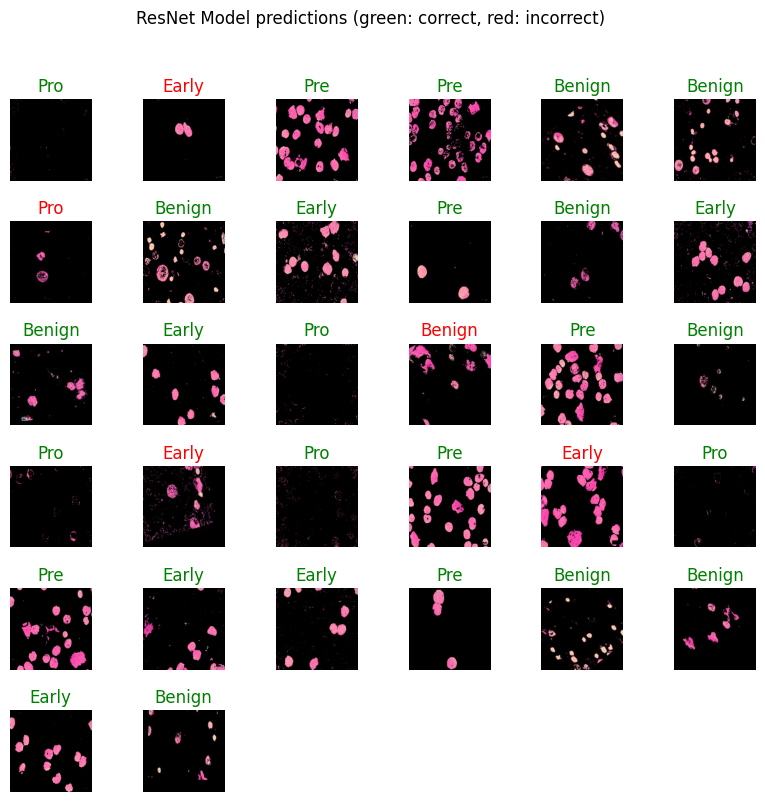

In [ ]:
predicted_ids_ResNet = np.argmax(tf_model_predictions_ResNet, axis=-1)
predicted_labels_ResNet = dataset_labels[predicted_ids_ResNet]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_ResNet[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_ResNet[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("ResNet Model predictions (green: correct, red: incorrect)")


In [ ]:
results = ResNet.evaluate(test_image_batch, test_label_batch)

1/1 [==============================] - 1s 1s/step - loss: 0.4634 - accuracy: 0.8438


In [ ]:
results

[0.4633964002132416, 0.84375]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_ResNet)
claRep

'              precision    recall  f1-score   support\n\n           0       0.90      0.82      0.86        11\n           1       0.67      1.00      0.80         6\n           2       1.00      0.78      0.88         9\n           3       0.83      0.83      0.83         6\n\n    accuracy                           0.84        32\n   macro avg       0.85      0.86      0.84        32\nweighted avg       0.87      0.84      0.85        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_ResNet)
accuracy = accuracy_score(true_label_ids, predicted_ids_ResNet)
precision = precision_score(true_label_ids, predicted_ids_ResNet, average='macro')
recall = recall_score(true_label_ids, predicted_ids_ResNet, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_ResNet, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[9 1 0 1]
 [0 6 0 0]
 [0 2 7 0]
 [1 0 0 5]]
Accuracy: 0.84375
Precision: 0.85
Recall: 0.8573232323232324
F1 Score: 0.8413690476190477


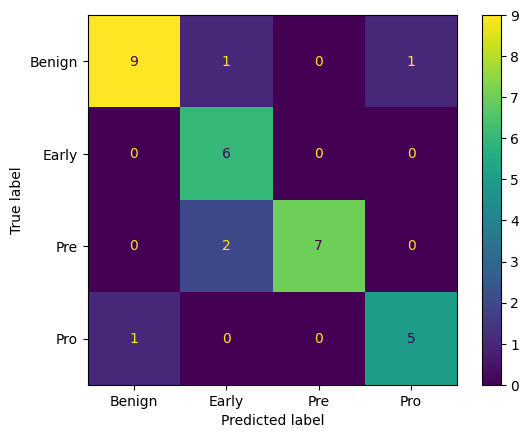

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Benign', 'Early', 'Pre', 'Pro'])
cm_display.plot()
plt.show()

Text(0, 0.5, 'TPR')

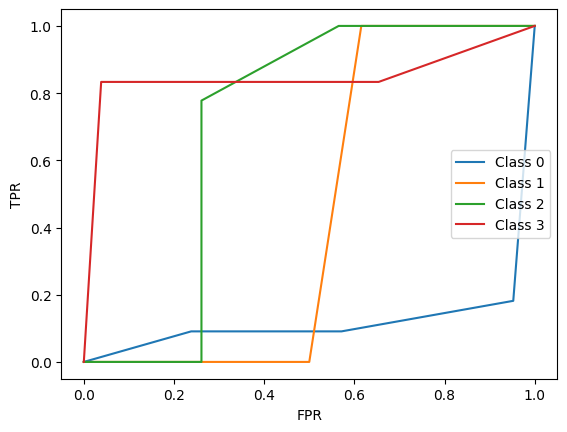

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

N_classes = 4
tpr,fpr,roc_auc = ([[]]*N_classes for _ in range(3))
f,ax = plt.subplots()
for i in range(N_classes):
    # fpr[i], tpr[i], _ = roc_curve(true_label_ids==i, predicted_ids_MobileNet)
    fpr[i], tpr[i], _ = roc_curve(true_label_ids==i, predicted_ids_ResNet)
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax.plot(fpr[i],tpr[i])
plt.legend(['Class {:d}'.format(d) for d in range(N_classes)])
plt.xlabel('FPR')
plt.ylabel('TPR')

# 3. VGG

In [ ]:
VGG_PATH = '/content/drive/MyDrive/CCPS-F2/CCPS/NewModels/VGG16.h5'

In [ ]:
VGG = tf.keras.models.load_model(VGG_PATH)

In [ ]:
tf_model_predictions_VGG = VGG.predict(test_image_batch)
tf_pred_dataframe_VGG = pd.DataFrame(tf_model_predictions_VGG)
tf_pred_dataframe_VGG.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe_VGG.head()

1/1 [==============================] - 6s 6s/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,0.003872,0.000136,0.000088,0.995904
1,0.225607,0.263575,0.454106,0.056713
2,0.001694,0.003942,0.994345,0.000019
3,0.000220,0.000005,0.999772,0.000002
4,0.964787,0.024551,0.001984,0.008678


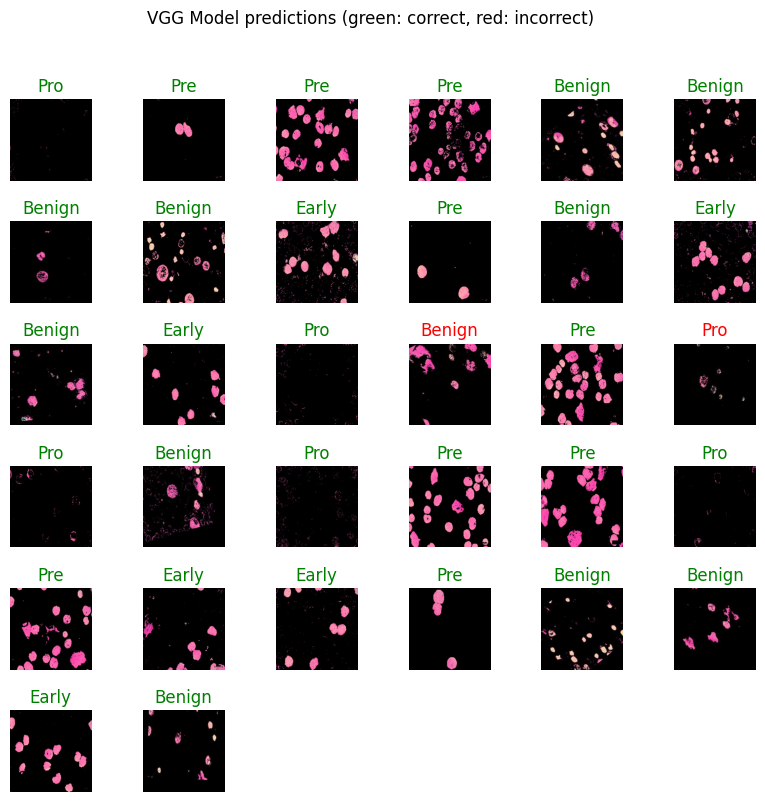

In [ ]:
predicted_ids_VGG = np.argmax(tf_model_predictions_VGG, axis=-1)
predicted_labels_VGG = dataset_labels[predicted_ids_VGG]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_VGG[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_VGG[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("VGG Model predictions (green: correct, red: incorrect)")

In [ ]:
results = VGG.evaluate(test_image_batch, test_label_batch)

1/1 [==============================] - 0s 380ms/step - loss: 0.1791 - acc: 0.9375


In [ ]:
results

[0.17911605536937714, 0.9375]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_VGG)
claRep

'              precision    recall  f1-score   support\n\n           0       0.91      0.91      0.91        11\n           1       1.00      1.00      1.00         6\n           2       1.00      1.00      1.00         9\n           3       0.83      0.83      0.83         6\n\n    accuracy                           0.94        32\n   macro avg       0.94      0.94      0.94        32\nweighted avg       0.94      0.94      0.94        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_VGG)
accuracy = accuracy_score(true_label_ids, predicted_ids_VGG)
precision = precision_score(true_label_ids, predicted_ids_VGG, average='macro')
recall = recall_score(true_label_ids, predicted_ids_VGG, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_VGG, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[10  0  0  1]
 [ 0  6  0  0]
 [ 0  0  9  0]
 [ 1  0  0  5]]
Accuracy: 0.9375
Precision: 0.9356060606060607
Recall: 0.9356060606060607
F1 Score: 0.9356060606060607


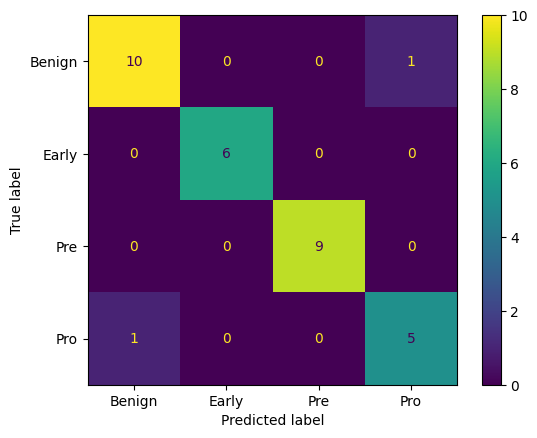

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Benign', 'Early', 'Pre', 'Pro'])
cm_display.plot()
plt.show()

Text(0, 0.5, 'TPR')

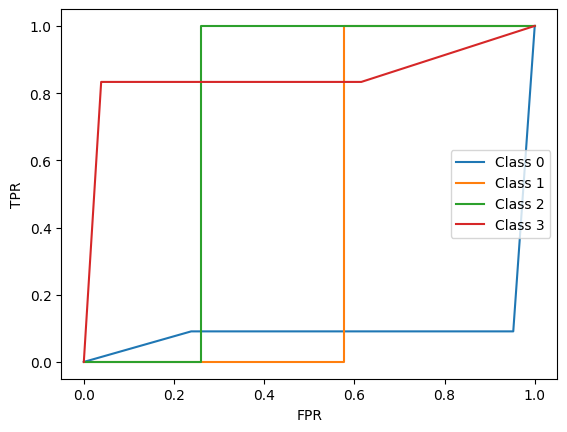

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

N_classes = 4
tpr,fpr,roc_auc = ([[]]*N_classes for _ in range(3))
f,ax = plt.subplots()
for i in range(N_classes):
    # fpr[i], tpr[i], _ = roc_curve(true_label_ids==i, predicted_ids_MobileNet)
    fpr[i], tpr[i], _ = roc_curve(true_label_ids==i, predicted_ids_VGG)
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax.plot(fpr[i],tpr[i])
plt.legend(['Class {:d}'.format(d) for d in range(N_classes)])
plt.xlabel('FPR')
plt.ylabel('TPR')

# 4. Xception

In [ ]:
Xception_PATH = '/content/drive/MyDrive/CCPS-F2/CCPS/NewModels/Xceptiontry2.h5'

In [ ]:
Xception = tf.keras.models.load_model(Xception_PATH)

In [ ]:
tf_model_predictions_Xception = Xception.predict(test_image_batch)
tf_pred_dataframe_Xception = pd.DataFrame(tf_model_predictions_Xception)
tf_pred_dataframe_Xception.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe_Xception.head()

1/1 [==============================] - 4s 4s/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,2.195032e-10,2.730344e-10,9.940863e-11,1.000000e+00
1,4.082426e-07,2.399468e-03,9.976001e-01,2.089065e-10
2,1.096890e-10,1.036895e-11,1.000000e+00,1.545200e-13
3,8.839522e-09,1.705146e-12,1.000000e+00,4.663283e-13
4,9.791053e-01,7.685316e-03,9.284439e-05,1.311649e-02


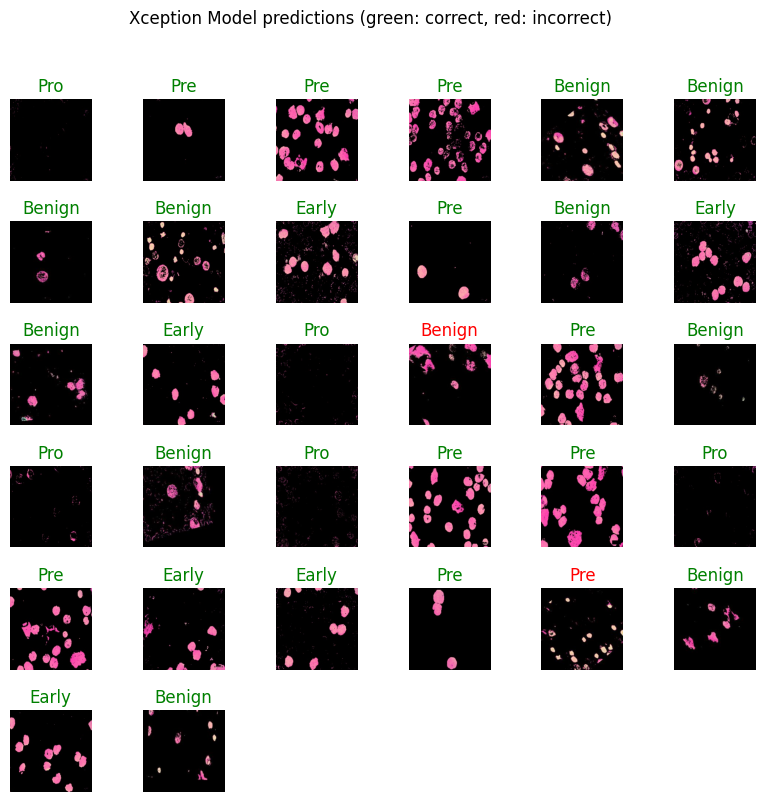

In [ ]:
predicted_ids_Xception = np.argmax(tf_model_predictions_Xception, axis=-1)
predicted_labels_Xception = dataset_labels[predicted_ids_Xception]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_Xception[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_Xception[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Xception Model predictions (green: correct, red: incorrect)")

In [ ]:
results = Xception.evaluate(test_image_batch, test_label_batch)

1/1 [==============================] - 1s 1s/step - loss: 0.6044 - accuracy: 0.9375


In [ ]:
results

[0.6043907403945923, 0.9375]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_Xception)
claRep

'              precision    recall  f1-score   support\n\n           0       0.91      0.91      0.91        11\n           1       1.00      1.00      1.00         6\n           2       0.90      1.00      0.95         9\n           3       1.00      0.83      0.91         6\n\n    accuracy                           0.94        32\n   macro avg       0.95      0.94      0.94        32\nweighted avg       0.94      0.94      0.94        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_Xception)
accuracy = accuracy_score(true_label_ids, predicted_ids_Xception)
precision = precision_score(true_label_ids, predicted_ids_Xception, average='macro')
recall = recall_score(true_label_ids, predicted_ids_Xception, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_Xception, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
 [[10  0  1  0]
 [ 0  6  0  0]
 [ 0  0  9  0]
 [ 1  0  0  5]]
Accuracy: 0.9375
Precision: 0.9522727272727273
Recall: 0.9356060606060607
F1 Score: 0.9413875598086126


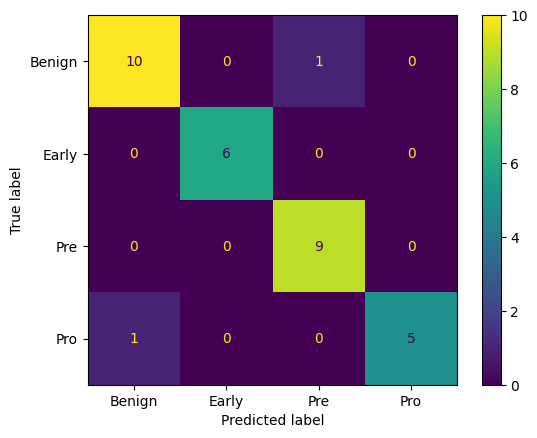

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Benign', 'Early', 'Pre', 'Pro'])
cm_display.plot()
plt.show()

Text(0, 0.5, 'TPR')

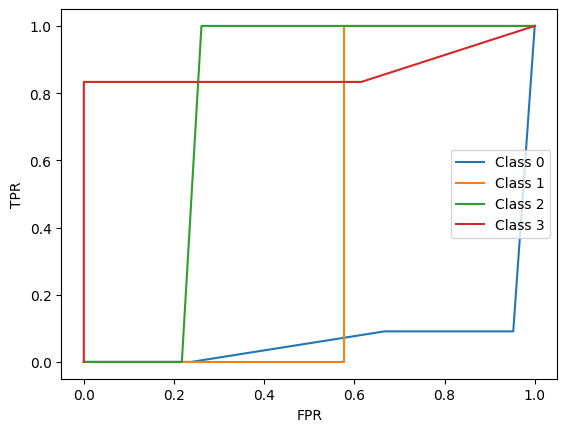

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

N_classes = 4
tpr,fpr,roc_auc = ([[]]*N_classes for _ in range(3))
f,ax = plt.subplots()
for i in range(N_classes):
    fpr[i], tpr[i], _ = roc_curve(true_label_ids.ravel()==i, predicted_ids_Xception.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax.plot(fpr[i],tpr[i])
plt.legend(['Class {:d}'.format(d) for d in range(N_classes)])
plt.xlabel('FPR')
plt.ylabel('TPR')

# 5. NasNet

In [ ]:
NasNet_PATH = '/content/drive/MyDrive/CCPS-F2/CCPS/NewModels/NasNetLarge.h5'

In [ ]:
NasNet = tf.keras.models.load_model(NasNet_PATH)

In [ ]:
tf_model_predictions_NasNet = NasNet.predict(test_image_batch)
tf_pred_dataframe_NasNet = pd.DataFrame(tf_model_predictions_NasNet)
tf_pred_dataframe_NasNet.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe_NasNet.head()

1/1 [==============================] - 11s 11s/step
Prediction results for the first elements


,Benign,Early,Pre,Pro
0,0.225250,0.262377,0.165432,0.346941
1,0.317316,0.228548,0.205165,0.248971
2,0.226618,0.124750,0.465678,0.182954
3,0.170514,0.112526,0.577440,0.139520
4,0.288702,0.224637,0.206457,0.280204


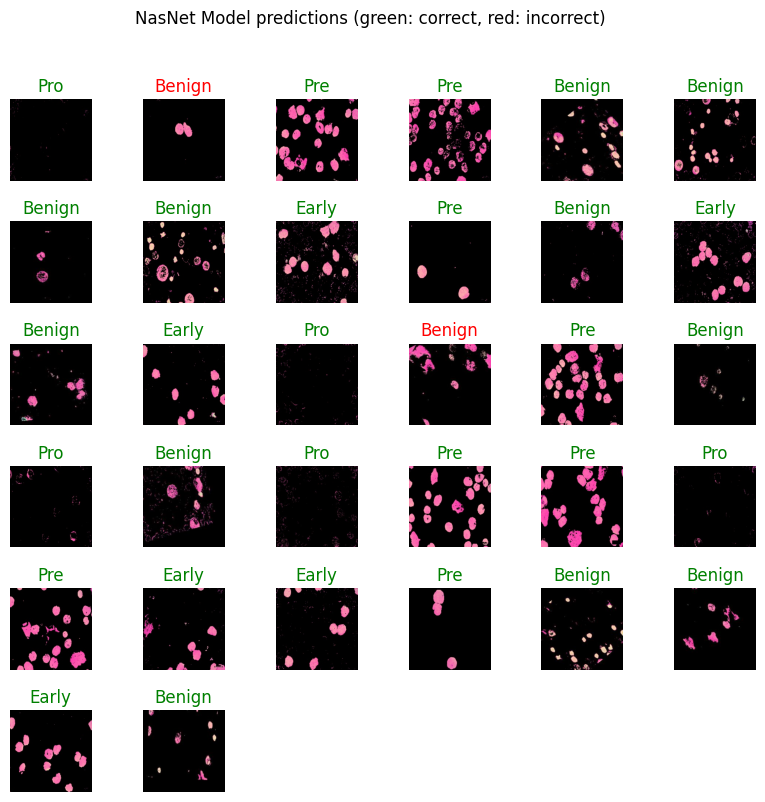

In [ ]:
predicted_ids_NasNet = np.argmax(tf_model_predictions_NasNet, axis=-1)
predicted_labels_NasNet = dataset_labels[predicted_ids_NasNet]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_NasNet[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_NasNet[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("NasNet Model predictions (green: correct, red: incorrect)")

In [ ]:
results = NasNet.evaluate(test_image_batch, test_label_batch)

1/1 [==============================] - 10s 10s/step - loss: 0.9468 - acc: 0.9375


In [ ]:
results

[0.9467534422874451, 0.9375]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_NasNet)
claRep

'              precision    recall  f1-score   support\n\n           0       0.85      1.00      0.92        11\n           1       1.00      1.00      1.00         6\n           2       1.00      0.89      0.94         9\n           3       1.00      0.83      0.91         6\n\n    accuracy                           0.94        32\n   macro avg       0.96      0.93      0.94        32\nweighted avg       0.95      0.94      0.94        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_NasNet)
accuracy = accuracy_score(true_label_ids, predicted_ids_NasNet)
precision = precision_score(true_label_ids, predicted_ids_NasNet, average='macro')
recall = recall_score(true_label_ids, predicted_ids_NasNet, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_NasNet, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[11  0  0  0]
 [ 0  6  0  0]
 [ 1  0  8  0]
 [ 1  0  0  5]]
Accuracy: 0.9375
Precision: 0.9615384615384616
Recall: 0.9305555555555556
F1 Score: 0.9417335115864527


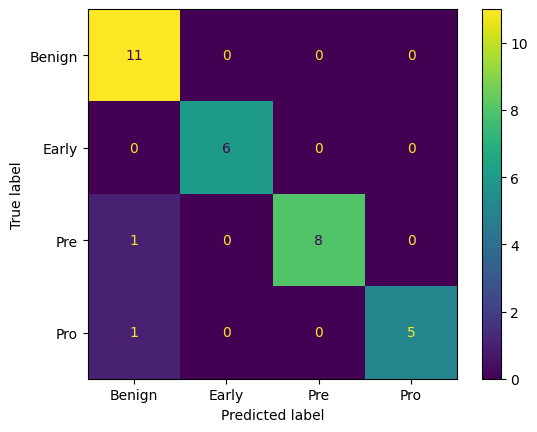

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Benign', 'Early', 'Pre', 'Pro'])
cm_display.plot()
plt.show()

Text(0, 0.5, 'TPR')

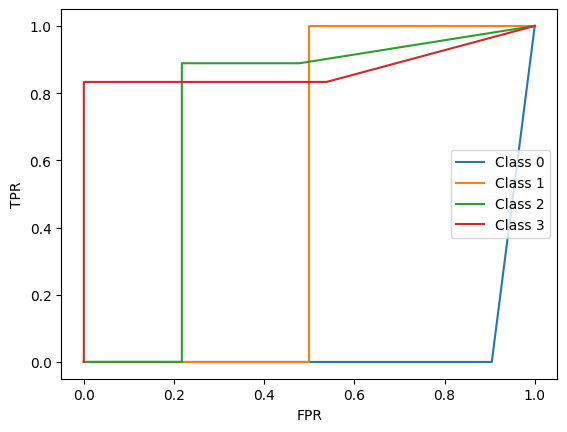

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

N_classes = 4
tpr,fpr,roc_auc = ([[]]*N_classes for _ in range(3))
f,ax = plt.subplots()
for i in range(N_classes):
    # fpr[i], tpr[i], _ = roc_curve(true_label_ids==i, predicted_ids_MobileNet)
    fpr[i], tpr[i], _ = roc_curve(true_label_ids.ravel()==i, predicted_ids_NasNet.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax.plot(fpr[i],tpr[i])
plt.legend(['Class {:d}'.format(d) for d in range(N_classes)])
plt.xlabel('FPR')
plt.ylabel('TPR')

# Ensemble

In [ ]:
prediction = np.array([])
for i in range(len(true_label_ids)):
  predicted_ids = np.array([predicted_ids_MobileNet[i], predicted_ids_ResNet[i],predicted_ids_Xception[i], predicted_ids_VGG[i], predicted_ids_NasNet[i]])
  unique_elements, counts = np.unique(predicted_ids, return_counts=True)
  max_count_index = np.argmax(counts)
  max_count_element = unique_elements[max_count_index]
  prediction = np.append(prediction, max_count_element)

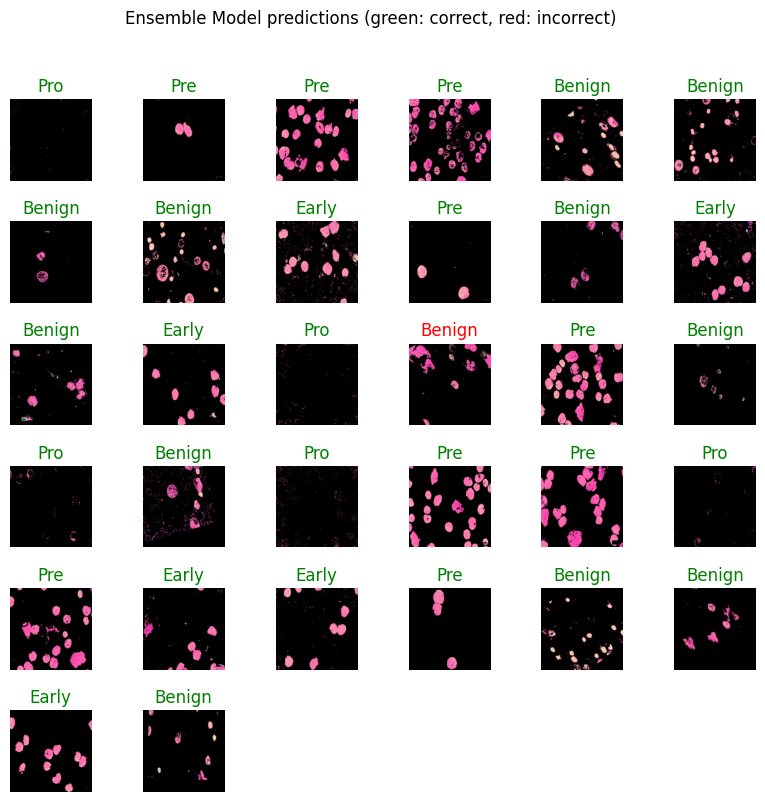

In [ ]:
prediction_ids = prediction.astype('int64')
predicted_labels = dataset_labels[prediction_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if prediction_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Ensemble Model predictions (green: correct, red: incorrect)")

In [ ]:
true_label_ids == prediction_ids

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
claRep = classification_report(true_label_ids, prediction)
claRep

'              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96        11\n           1       1.00      1.00      1.00         6\n           2       1.00      1.00      1.00         9\n           3       1.00      0.83      0.91         6\n\n    accuracy                           0.97        32\n   macro avg       0.98      0.96      0.97        32\nweighted avg       0.97      0.97      0.97        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, prediction)
accuracy = accuracy_score(true_label_ids, prediction)
precision = precision_score(true_label_ids, prediction, average='macro')
recall = recall_score(true_label_ids, prediction, average='macro')
f1 = f1_score(true_label_ids, prediction, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[11  0  0  0]
 [ 0  6  0  0]
 [ 0  0  9  0]
 [ 1  0  0  5]]
Accuracy: 0.96875
Precision: 0.9791666666666666
Recall: 0.9583333333333334
F1 Score: 0.9664031620553359


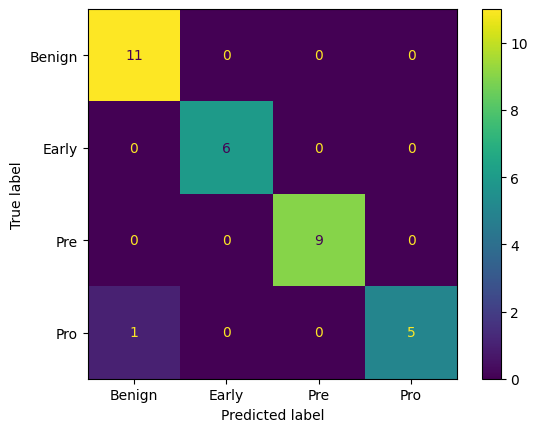

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Benign', 'Early', 'Pre', 'Pro'])
cm_display.plot()
plt.show()

Text(0, 0.5, 'TPR')

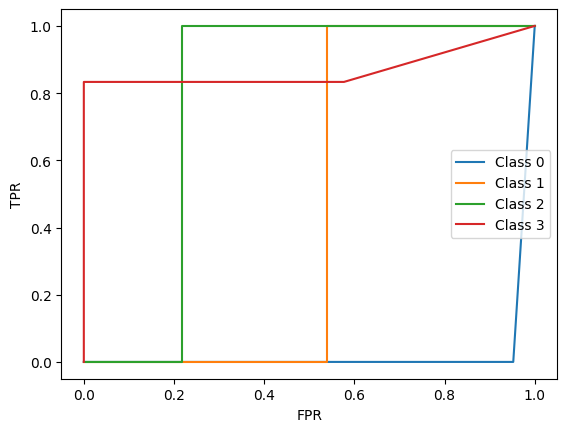

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

N_classes = 4
tpr,fpr,roc_auc = ([[]]*N_classes for _ in range(3))
f,ax = plt.subplots()
for i in range(N_classes):
    # fpr[i], tpr[i], _ = roc_curve(true_label_ids==i, predicted_ids_MobileNet)
    fpr[i], tpr[i], _ = roc_curve(true_label_ids.ravel()==i, prediction.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax.plot(fpr[i],tpr[i])
plt.legend(['Class {:d}'.format(d) for d in range(N_classes)])
plt.xlabel('FPR')
plt.ylabel('TPR')